In [2]:
from os import environ, path
from absl import logging as absl_logging
from IPython.display import clear_output
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.callbacks import EarlyStopping
import os
from pathlib import Path
from glob import glob
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2


2023-11-29 19:42:29.037842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 19:42:29.037880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 19:42:29.039077: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 19:42:29.162466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
##Variables
IMAGE_SIZE = 128
BATCH_SIZE = 8
NUM_CLASSES = 104
LEARNING_RATE=0.002
WEIGHT_DECAY=0.0001
MOMENTUM=0.9
CLIPNORM=10.0
EPOCHS=25

In [4]:
if os.getenv("COLAB_RELEASE_TAG"):
    isInColab = True
else:
    isInColab = False

if isInColab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_folder_path = Path(os.getcwd() + r"/gdrive/My Drive/FoodSeg103/Images")
    models_path = Path(os.getcwd() + r"/gdrive/My Drive/Models")
else:
    data_folder_path = Path(os.getcwd()+ r"/Dataset/FoodSeg103/Images")
    models_path = Path(os.getcwd() + r"/Models")
try:
    os.mkdir(models_path)
    print("Models folder created for saving models")
except:
    print("Models folder already exists")


Models folder already exists


In [5]:
##Data loading
def load_images_combined(NUM_TRAIN_IMAGES, NUM_VAL_IMAGES):
    train_images_path = Path(data_folder_path, r"img_dir/train")
    train_ann_path = Path(data_folder_path, r"ann_dir/train")
    test_images_path = Path(data_folder_path, r"img_dir/test")
    test_ann_path = Path(data_folder_path, r"ann_dir/test")
    
    train_images_paths = sorted(os.listdir(train_images_path))
    train_ann_paths = sorted(os.listdir(train_ann_path))
    test_images_paths = sorted(os.listdir(test_images_path))
    test_ann_paths = sorted(os.listdir(test_ann_path))

    train_images = train_images_paths[:NUM_TRAIN_IMAGES]
    train_masks = train_ann_paths[:NUM_TRAIN_IMAGES]
    val_images = test_images_paths[:NUM_VAL_IMAGES]
    val_masks = test_ann_paths[:NUM_VAL_IMAGES]

    train_images = [str(Path(train_images_path, img)) for img in train_images]
    train_masks = [str(Path(train_ann_path, img)) for img in train_masks]
    val_images = [str(Path(test_images_path, img)) for img in val_images]
    val_masks = [str(Path(test_ann_path, img)) for img in val_masks]

    image_paths=sorted(train_images + val_images)
    mask_paths=sorted(train_masks + val_masks)

    return image_paths, mask_paths

image_paths, mask_paths = load_images_combined(4983, 2135)



In [15]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from keras.utils import to_categorical
import numpy as np
from PIL import Image

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, validation_split=0.2):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.validation_split = validation_split

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_x, batch_y = self.load_data(start, end)

        return batch_x, batch_y
        

    def load_data(self, start, end):
        images = []
        masks = []
        paths = self.image_paths
        for i in range(start, min(end, len(self.image_paths))):
            img_img = tf.io.read_file(self.image_paths[i])
            img = tf.image.decode_png(img_img, channels=3)
            img.set_shape([None, None, 3])
            img = tf.image.resize(images=img, size=[IMAGE_SIZE, IMAGE_SIZE])
            img = tf.keras.applications.resnet50.preprocess_input(img)
            images.append(img)

            mask_img = tf.io.read_file(self.mask_paths[i])
            mask = tf.image.decode_png(mask_img, channels=1)
            mask.set_shape([None, None, 1])
            mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
            one_hot_mask=to_categorical(mask,num_classes=NUM_CLASSES)
            masks.append(one_hot_mask)
        return np.array(images), np.array(masks)


train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2)

train_data_generator = CustomDataGenerator(train_image_paths, train_mask_paths, batch_size=BATCH_SIZE)
val_data_generator = CustomDataGenerator(val_image_paths, val_mask_paths,  batch_size=BATCH_SIZE)

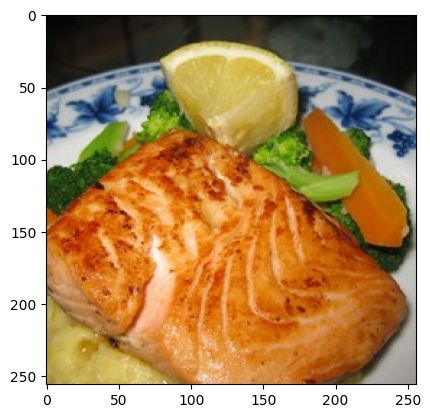

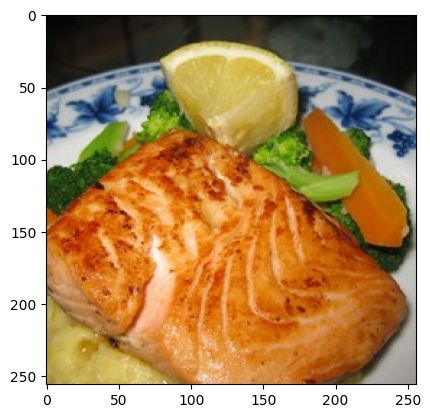

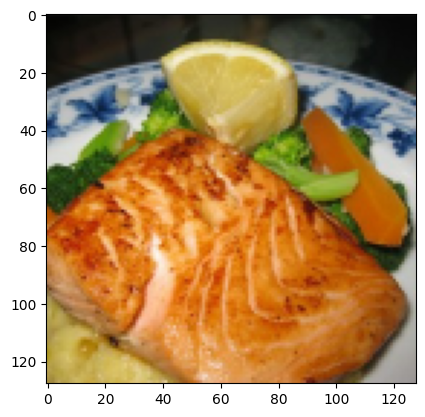

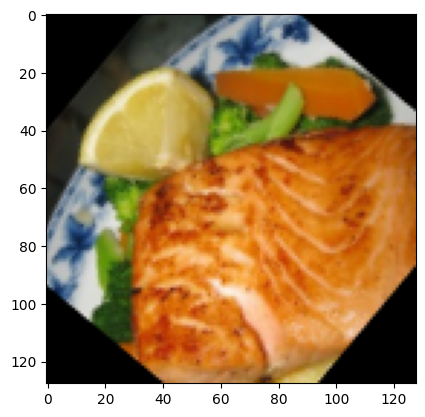

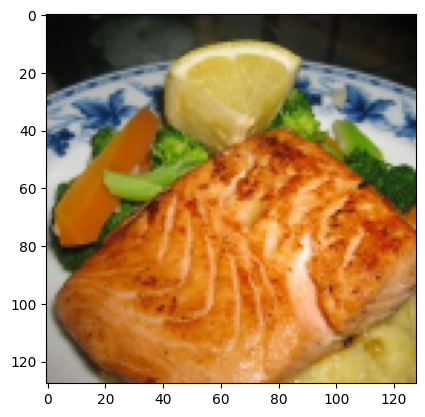

In [19]:
raw_img = tf.io.read_file(train_image_paths[0])
png_img = tf.image.decode_png(raw_img, channels=3)
plt.imshow(png_img)
plt.show()

png_img.set_shape([None, None, 3])
plt.imshow(png_img)
plt.show()

img = tf.image.resize(images=png_img, size=[IMAGE_SIZE, IMAGE_SIZE])
img_ceil = np.ceil(img) / 256
plt.imshow(img_ceil)
plt.show()



rotated = tf.keras.Sequential([
  layers.RandomRotation(0.2, fill_mode='constant')])
result_rot = rotated(img_ceil)
plt.imshow(result_rot)
plt.show()

flipped = tf.keras.Sequential([
  layers.RandomFlip('horizontal')])
result_flip = flipped(img_ceil)
plt.imshow(result_flip)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


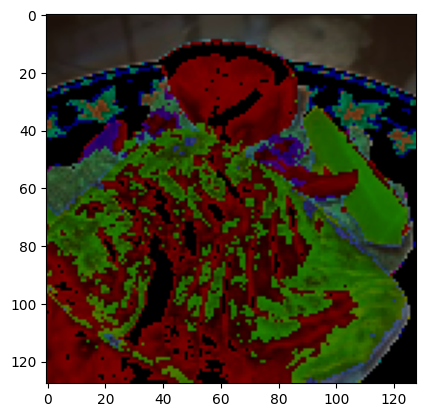

In [17]:
cv2.destroyAllWindows()

im, m = train_data_generator.load_data(0, 1)

x = m[0]
m[0][50][50]




newAnn = np.zeros((IMAGE_SIZE,IMAGE_SIZE), dtype=np.int8)
for i in range(IMAGE_SIZE):
    for j in range(IMAGE_SIZE):
        newAnn[i][j] = np.argmax(x[i][j])


# y = cv2.cvtColor(im[0], cv2.COLOR_BGR2RGB) 
# plt.imshow(im[0])
im[0]
wiw = np.ceil(im[0] + 128).astype(np.int8)
plt.imshow(wiw)
# cv2.imshow("Image", newAnn)
